# Business Data Challenge - Team 1

In [22]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
import warnings
import io
import matplotlib.pyplot as plt


Configuration de l'accès aux données

In [2]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [3]:
# Import cleaning and merge functions

exec(open('0_Cleaning_and_merge_functions.py').read())

exec(open('0_KPI_functions.py').read())

# Ignore warning
warnings.filterwarnings('ignore')


In [4]:
def load_dataset_2(directory_path, file_name):
    """
    This function loads csv file
    """
    file_path = "bdc2324-data" + "/" + directory_path + "/" + directory_path + file_name + ".csv"
    with fs.open(file_path, mode="rb") as file_in:
        df = pd.read_csv(file_in, sep=",")

    # drop na :
    #df = df.dropna(axis=1, thresh=len(df))
    # if identifier in table : delete it
    if 'identifier' in df.columns:
        df = df.drop(columns = 'identifier')
    return df

In [5]:
def export_in_temporary(df, output_name):
    print('Export of dataset :', output_name)
    FILE_PATH_OUT_S3 = "ajoubrel-ensae/Temporary" + "/" + output_name + '.csv'
    with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
        df.to_csv(file_out, index = False)

In [15]:
def save_file_s3(File_name, type_of_activity):
    image_buffer = io.BytesIO()
    plt.savefig(image_buffer, format='png')
    image_buffer.seek(0)
    FILE_PATH = f"projet-bdc2324-team1/stat_desc/{type_of_activity}/"
    FILE_PATH_OUT_S3 = FILE_PATH + File_name + type_of_activity + '.png'
    with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
        s3_file.write(image_buffer.read())
    plt.close()

In [37]:
def taux_partner(campany_nb) :

    is_partner = load_dataset_2(campany_nb, 'customersplus')[['is_partner']].astype(int)
    percentage_partner = (is_partner['is_partner'].mean()) * 100
    
    return percentage_partner
    


In [43]:
a = 0
for nb in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]:
    a += taux_partner(nb)

print(a/14)

0.0


# Cleaning target area and tags

In [14]:
def concatenate_names(names):
    return ', '.join(names)

def targets_KPI(df_target = None):
    
    df_target['target_name'] = df_target['target_name'].fillna('').str.lower()

    # Target name cotegory musees / 
    df_target['target_jeune'] = df_target['target_name'].str.contains('|'.join(['jeune', 'pass_culture', 'etudiant', '12-25 ans', 'student', 'jeunesse']), case=False).astype(int)
    df_target['target_optin'] = df_target['target_name'].str.contains('|'.join(['optin' ,'opt-in']), case=False).astype(int)
    df_target['target_optout'] = df_target['target_name'].str.contains('|'.join(['optout', 'unsubscribed']), case=False).astype(int)
    df_target['target_scolaire'] = df_target['target_name'].str.contains('|'.join(['scolaire' , 'enseignant', 'chercheur', 'schulen', 'école']), case=False).astype(int)
    df_target['target_entreprise'] = df_target['target_name'].str.contains('|'.join(['b2b', 'btob', 'cse']), case=False).astype(int)
    df_target['target_famille'] = df_target['target_name'].str.contains('|'.join(['famille', 'enfants', 'family']), case=False).astype(int)
    df_target['target_newsletter'] = df_target['target_name'].str.contains('|'.join(['nl', 'newsletter']), case=False).astype(int)
    
    # Target name category for sport compagnies
    df_target['target_abonne'] = ((
                            df_target['target_name']
                            .str.contains('|'.join(['abo', 'adh']), case=False)
                            & ~df_target['target_name'].str.contains('|'.join(['hors abo', 'anciens abo']), case=False)
                            ).astype(int))
    
    df_target_categorie = df_target.groupby('customer_id')[['target_jeune', 'target_optin', 'target_optout', 'target_scolaire', 'target_entreprise', 'target_famille', 'target_newsletter', 'target_abonne']].max()
    
    target_agg = df_target.groupby('customer_id').agg(
        nb_targets=('target_name', 'nunique')  # Utilisation de tuples pour spécifier les noms de colonnes
        # all_targets=('target_name', concatenate_names),
        # all_target_types=('target_type_name', concatenate_names)
        ).reset_index()

    target_agg['nb_targets'] = (target_agg['nb_targets'] - (target_agg['nb_targets'].mean())) / (target_agg['nb_targets'].std())
    
    target_agg = pd.merge(target_agg, df_target_categorie, how='left', on='customer_id')
    
    return target_agg

In [15]:
targets_KPI(display_input_databases('5', file_name = "target_information"))

File path :  projet-bdc2324-team1/0_Input/Company_5/target_information.csv


customer_id  nb_targets  target_jeune  target_optin  target_optout  \
0            160516    6.938264             0             1              0   
1            160517   10.357387             0             1              1   
2            160518    5.228703             0             1              1   
3            160519    6.083483             0             1              1   
4            160520    2.949288             0             1              0   
...             ...         ...           ...           ...            ...   
471205      6405875   -0.754762             0             0              1   
471206      6405905   -0.469835             0             0              1   
471207      6405909   -0.754762             0             0              1   
471208      6405917   -0.754762             0             0              1   
471209      6405963   -0.754762             0             0              1   

        target_scolaire  target_entreprise  target_famille  target_newsletter  \
0                     0                  1               0                  0   
1                     0                  0               0                  0   
2                     0                  0               0                  0   
3                     0                  0               1                  0   
4                     0                  0               0                  0   
...                 ...                ...             ...                ...   
471205                0                  0               0                  0   
471206                0                  0               0                  0   
471207                0                  0               0                  0   
471208                0                  0               0                  0   
471209                0                  0               0                  0   

        target_abonne  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  
...               ...  
471205              0  
471206              0  
471207              0  
471208              0  
471209              0  

[471210 rows x 10 columns]

In [35]:
def targets_name_category(df_target=None):
    if df_target is None:
        return None
    
    df_target['target_name'] = df_target['target_name'].fillna('').str.lower()

    # Target name category for museums
    df_target['target_jeune'] = df_target['target_name'].str.contains('|'.join(['jeune', 'pass_culture', 'etudiant', '12-25 ans', 'student', 'jeunesse']), case=False).astype(int)
    df_target['target_optin'] = df_target['target_name'].str.contains('|'.join(['optin', 'opt-in']), case=False).astype(int)
    df_target['target_optout'] = df_target['target_name'].str.contains('|'.join(['optout', 'unsubscribed']), case=False).astype(int)
    df_target['target_scolaire'] = df_target['target_name'].str.contains('|'.join(['scolaire', 'enseignant', 'chercheur', 'schulen', 'école']), case=False).astype(int)
    df_target['target_entreprise'] = df_target['target_name'].str.contains('|'.join(['b2b', 'btob', 'cse']), case=False).astype(int)
    df_target['target_famille'] = df_target['target_name'].str.contains('|'.join(['famille', 'enfants', 'family']), case=False).astype(int)
    df_target['target_newsletter'] = df_target['target_name'].str.contains('|'.join(['nl', 'newsletter']), case=False).astype(int)
    
    # Target name category for sport companies
    df_target['target_abonne'] = ((df_target['target_name']
                                    .str.contains('|'.join(['abo', 'adh']), case=False)
                                    & ~df_target['target_name'].str.contains('|'.join(['hors abo', 'anciens abo']), case=False))
                                  .astype(int))

    list_target_jeune = df_target[df_target['target_jeune'] == 1]['target_name'].unique()
    list_target_optin = df_target[df_target['target_optin'] == 1]['target_name'].unique()
    list_target_optout = df_target[df_target['target_optout'] == 1]['target_name'].unique()
    list_target_scolaire = df_target[df_target['target_scolaire'] == 1]['target_name'].unique()
    list_target_entreprise = df_target[df_target['target_entreprise'] == 1]['target_name'].unique()
    list_target_famille = df_target[df_target['target_famille'] == 1]['target_name'].unique()
    list_target_newsletter = df_target[df_target['target_newsletter'] == 1]['target_name'].unique()
    list_target_abonne = df_target[df_target['target_abonne'] == 1]['target_name'].unique()

    list_all = [list_target_jeune, list_target_optin, list_target_optout, list_target_scolaire,
                list_target_entreprise, list_target_famille, list_target_newsletter, list_target_abonne]

    category_name = ['target_jeune', 'target_optin', 'target_optout', 'target_scolaire',
                     'target_entreprise', 'target_famille', 'target_newsletter', 'target_abonne']
    
    liste_category = pd.DataFrame({'category_name': category_name,
                                   'list_target_name': list_all})
    
    return liste_category


In [36]:
pd.set_option('display.max_colwidth', None)
targets_name_category(display_input_databases('7', file_name = "target_information"))

File path :  projet-bdc2324-team1/0_Input/Company_7/target_information.csv


category_name  \
0       target_jeune   
1       target_optin   
2      target_optout   
3    target_scolaire   
4  target_entreprise   
5     target_famille   
6  target_newsletter   
7      target_abonne   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              list_target_name  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           [jeunesses vaudoises, etudiant hors ssc 22-23, student supporter club, etudiants hors epfl, student supporter club ehl, etudiants]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           []  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           []  
3                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
#export_inv_temporary(target_agg, 'Target_kpi_concatenate')

In [47]:
companies = {'musee' : ['1', '2', '3', '4'], # , '101'
            'sport': ['5', '6', '7', '8', '9'],
            'musique' : ['10', '11', '12', '13', '14']}

nb_compagnie = companies['musique']

def load_files(nb_compagnie):
    targets = pd.DataFrame()
    
    # début de la boucle permettant de générer des datasets agrégés pour les 5 compagnies de spectacle
    for directory_path in nb_compagnie:
        df_customerplus_clean_0 = display_input_databases(directory_path, file_name = "customerplus_cleaned")
        df_target_information = display_input_databases(directory_path, file_name = "target_information")
        
        df_target_KPI = targets_KPI(df_target = df_target_information)
        df_target_KPI = pd.merge(df_customerplus_clean_0[['customer_id']], df_target_KPI, how = 'left', on = 'customer_id')

        targets_columns = list(df_target_KPI.columns)
        targets_columns.remove('customer_id')
        df_target_KPI[targets_columns] = df_target_KPI[targets_columns].fillna(0)
        
    # creation de la colonne Number compagnie, qui permettra d'agréger les résultats
        df_target_KPI["number_company"]=int(directory_path)
    
    # Traitement des index
        df_target_KPI["customer_id"]= directory_path + '_' +  df_target_KPI['customer_id'].astype('str')
    
    # Concaténation
        targets = pd.concat([targets, df_target_KPI], ignore_index=True)
        
    return targets

targets = load_files(nb_compagnie)

File path :  projet-bdc2324-team1/0_Input/Company_10/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_10/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_11/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_11/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_12/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_12/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_13/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_13/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_14/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_14/target_information.csv


In [48]:

def target_description(targets, type_of_activity):

    describe_target = targets.groupby('number_company').agg(
        prop_target_jeune=('target_jeune', lambda x: (x.sum() / x.count())*100),
        prop_target_scolaire=('target_scolaire', lambda x: (x.sum() / x.count())*100),
        prop_target_entreprise=('target_entreprise', lambda x: (x.sum() / x.count())*100),
        prop_target_famille=('target_famille', lambda x: (x.sum() / x.count())*100),
        prop_target_optin=('target_optin', lambda x: (x.sum() / x.count())*100),
        prop_target_optout=('target_optout', lambda x: (x.sum() / x.count())*100),
        prop_target_newsletter=('target_newsletter', lambda x: (x.sum() / x.count())*100),
        prop_target_abonne=('target_abonne', lambda x: (x.sum() / x.count())*100))

    plot = describe_target.plot.bar()
    
    # Adding a title
    plot.set_title("Distribution of Targets by Category")
    
    # Adding labels for x and y axes
    plot.set_xlabel("Company Number")
    plot.set_ylabel("Target Proportion")

    plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center')

    
    # Adding a legend
    plot.legend(["Youth", "School", "Enterprise", "Family", "Optin", "Optout", "Newsletter", "Subscriber"], title="Target Category")

    # save_file_s3("target_category_proportion_", type_of_activity)
    return plot

<Axes: title={'center': 'Distribution of Targets by Category'}, xlabel='Company Number', ylabel='Target Proportion'>

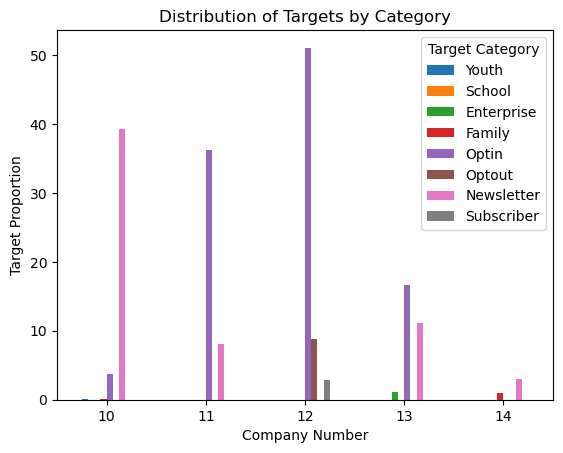

In [49]:
target_description(targets, 'musique')

# Brouillon

In [ ]:

def display_covering_time(df, company, datecover):
    """
    This function draws the time coverage of each company
    """
    min_date = df['purchase_date'].min().strftime("%Y-%m-%d")
    max_date = df['purchase_date'].max().strftime("%Y-%m-%d")
    datecover[company] = [datetime.strptime(min_date, "%Y-%m-%d") + timedelta(days=x) for x in range((datetime.strptime(max_date, "%Y-%m-%d") - datetime.strptime(min_date, "%Y-%m-%d")).days)]
    print(f'Couverture Company {company} : {min_date} - {max_date}')
    return datecover


def compute_time_intersection(datecover):
    """
    This function returns the time coverage for all companies
    """
    timestamps_sets = [set(timestamps) for timestamps in datecover.values()]
    intersection = set.intersection(*timestamps_sets)
    intersection_list = list(intersection)
    formated_dates = [dt.strftime("%Y-%m-%d") for dt in intersection_list]
    return sorted(formated_dates)


def df_coverage_modelization(sport, coverage_features = 0.7):
    """
    This function returns start_date, end_of_features and final dates
    that help to construct train and test datasets
    """
    datecover = {}
    for company in sport:
        df_products_purchased_reduced = display_input_databases(company, file_name = "products_purchased_reduced",
                                                          datetime_col = ['purchase_date'])
        datecover = display_covering_time(df_products_purchased_reduced, company, datecover)
    #print(datecover.keys())
    dt_coverage = compute_time_intersection(datecover)
    start_date = dt_coverage[0]
    end_of_features = dt_coverage[int(0.7 * len(dt_coverage))]
    final_date = dt_coverage[-1]
    return start_date, end_of_features, final_date
 

# Bases non communes : mise à plat

In [ ]:
companies = {'musee' : ['1', '2', '3', '4'],
            'sport': ['5', '6', '7', '8', '9'],
            'musique' : ['10', '11', '12', '13', '14']}

all_companies = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']

In [ ]:
companies_databases = pd.DataFrame()

for i in all_companies:
    company_databases = pd.DataFrame({'company_number' : [i]})

    BUCKET = "bdc2324-data/"+i
    for base in fs.ls(BUCKET):
        match = re.search(r'\/(\d+)\/(\d+)([a-zA-Z_]+)\.csv$', base)
        if match:
            nom_base = match.group(3)
            company_databases[nom_base] = 1

    companies_databases = pd.concat([companies_databases, company_databases])

In [ ]:
pd.set_option("display.max_columns", None)
companies_databases


In [ ]:
pd.reset_option("display.max_columns")

# Debut Travail 25/02

## Base communes au types Musée

In [ ]:
for i in companies['musique']:
    BUCKET = "bdc2324-data/"+i
    liste_base = []
    for base in fs.ls(BUCKET):
        match = re.search(r'\/(\d+)\/(\d+)([a-zA-Z_]+)\.csv$', base)
        if match:
            nom_base = match.group(3)
            liste_base.append(nom_base)
    globals()['base_'+i] = liste_base


In [ ]:
# Trouver l'intersection entre les cinq listes
intersection = set(base_1).intersection(base_2, base_3, base_4, base_101)

# Convertir le résultat en liste si nécessaire
intersection_liste = list(intersection)

print(intersection_liste)

In [ ]:
# Trouver l'intersection entre les cinq listes
intersection = set(base_10).intersection(base_12, base_13, base_14, base_11)

# Convertir le résultat en liste si nécessaire
intersection_liste = list(intersection)

print(intersection_liste)

In [ ]:
len(intersection_liste)

In [ ]:
df1_tags = load_dataset_2("1", "tags")

In [ ]:
df1_structure_tag_mappings = load_dataset_2("1", 'structure_tag_mappings')

In [ ]:
df1_customersplus = load_dataset_2("1", "customersplus")

In [ ]:
df1_customersplus.groupby('structure_id')['id'].count().reset_index().sort_values('id', ascending=False).head(20)

In [ ]:
df1_customersplus['structure_id'].isna().sum() / len(df1_customersplus['structure_id'])

In [ ]:
len(df1_structure_tag_mappings)

In [ ]:
df1_structure_tag_mappings.groupby('tag_id')['structure_id'].count().reset_index().sort_values('structure_id', ascending=False).head(20)

In [ ]:
?np.sort_values()

In [ ]:
def info_colonnes_dataframe(df):
    # Créer une liste pour stocker les informations sur chaque colonne
    infos_colonnes = []

    # Parcourir les colonnes du DataFrame
    for nom_colonne, serie in df.items():  # Utiliser items() au lieu de iteritems()
        # Calculer le taux de valeurs manquantes
        taux_na = serie.isna().mean() * 100

        # Ajouter les informations à la liste
        infos_colonnes.append({
            'Nom_colonne': nom_colonne,
            'Type_colonne': str(serie.dtype),
            'Taux_NA': taux_na
        })

    # Créer une nouvelle DataFrame à partir de la liste d'informations
    df_infos_colonnes = pd.DataFrame(infos_colonnes)

    return df_infos_colonnes

In [ ]:
info_colonnes_dataframe(df1_tags)

In [ ]:
info_colonnes_dataframe(df1_structure_tag_mappings)

In [ ]:
pd.set_option('display.max_colwidth', None)

print(df1_tags['name'])

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
print(df1_tags['name'])

## KPI sur target_type

In [ ]:
pd.set_option('display.max_colwidth', None)


Raisonnement : on prends les target_type qui représente 90% des clients et on fait des catégories dessus.

In [ ]:
def print_main_target(tenant_id, nb_print = 40):
    df_target = display_input_databases(tenant_id, "target_information")

    print('Nombre de ciblage : ', len(df_target))
    nb_customers = df_target['customer_id'].nunique()
    print('Nombre de client avec étiquette target : ', nb_customers) 

    nb_custumers_per_target = df_target.groupby("target_name")['customer_id'].count().reset_index().sort_values('customer_id', ascending=False)
    nb_custumers_per_target['cumulative_customers'] = nb_custumers_per_target['customer_id'].cumsum()/len(df_target)
    nb_custumers_per_target['customer_id'] = nb_custumers_per_target['customer_id']/nb_customers

    return nb_custumers_per_target.head(nb_print)

In [ ]:
pd.set_option("max_colwidth", None)
print_main_target('1', 60)

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
print_main_target('2', 25)

In [ ]:
print_main_target('3', 70)

In [ ]:
print_main_target('4', 100)

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:


print_main_target('5', 100)

In [ ]:
print_main_target('6', 100)

In [ ]:
print_main_target('7', 100)

In [ ]:
print_main_target('8', 100)

In [ ]:
print_main_target('9', 100)

In [ ]:
print_main_target('10', 100)

In [ ]:
print_main_target('11', 100)


In [ ]:
print_main_target('12', 100)


In [ ]:
print_main_target('13', 100)


In [ ]:
print_main_target('14', 100)


## KPI sur tags

In [ ]:
customersplus = load_dataset_2("4", "customersplus")[['id', 'structure_id']]

In [ ]:
structure_tag_mappings = load_dataset_2('4', "structure_tag_mappings")[['structure_id', 'tag_id']]

In [ ]:
customersplus[customersplus['structure_id'].notna()]['structure_id'].nunique()

In [ ]:
len(customersplus[customersplus['structure_id'].notna()])

In [ ]:
structure_tag_mappings['structure_id'].nunique()

In [ ]:
def tags_information(tenant_id, first_tags):

    customersplus = load_dataset_2(tenant_id, "customersplus")[['id', 'structure_id']]
    customersplus.rename(columns = {'id' : 'customer_id'}, inplace = True)
    tags = load_dataset_2(tenant_id, "tags")[['id', 'name']]
    tags.rename(columns = {'id' : 'tag_id', 'name' : 'tag_name'}, inplace = True)
    structure_tag_mappings = load_dataset_2(tenant_id, "structure_tag_mappings")[['structure_id', 'tag_id']]
    
    customer_tags = pd.merge(customersplus, structure_tag_mappings, on = 'structure_id', how = 'left')
    customer_tags = pd.merge(customer_tags, tags, on = 'tag_id', how = 'inner')
    
    nb_customers_with_tag = customer_tags['customer_id'].nunique()
    
    print('Nombre de client avec tag : ', nb_customers_with_tag)
    print('Proportion de clients avec tags : ', nb_customers_with_tag/len(customersplus))
    print('Moyenne de tags par client : ', len(customer_tags)/nb_customers_with_tag)
    
    info = customer_tags.groupby(['tag_id', 'tag_name'])['customer_id'].count().reset_index().sort_values('customer_id', ascending = False).head(first_tags)

    return info

In [ ]:
tags_information("1", 20)

In [ ]:
tags_information("2", 20)

In [ ]:
load_dataset_2("2", "tags")[['id', 'name']]

In [ ]:
tags_information("3", 20)

In [ ]:
tags_information("4", 20)

In [ ]:
tags_information("101", 20)

## KPI product

In [ ]:
tenant_id = "1"

df_product = display_databases(tenant_id, file_name = "products_purchased_reduced", datetime_col = ['purchase_date'])

df_product.head()

In [ ]:
nb_tickets_per_events = df_product.groupby(['name_event_types', 'name_events'])['ticket_id'].count().reset_index().sort_values('ticket_id', ascending = False)
nb_tickets_per_events['prop_tickets'] = round(nb_tickets_per_events['ticket_id']/len(df_product), 3)
nb_tickets_per_events

# Fin travail 25/02

# Exemple sur Company 1

## customersplus.csv

In [ ]:
a = pd.DataFrame(df1_customersplus.info())

In [ ]:
def info_colonnes_dataframe(df):
    # Créer une liste pour stocker les informations sur chaque colonne
    infos_colonnes = []

    # Parcourir les colonnes du DataFrame
    for nom_colonne, serie in df.items():  # Utiliser items() au lieu de iteritems()
        # Calculer le taux de valeurs manquantes
        taux_na = serie.isna().mean() * 100

        # Ajouter les informations à la liste
        infos_colonnes.append({
            'Nom_colonne': nom_colonne,
            'Type_colonne': str(serie.dtype),
            'Taux_NA': taux_na
        })

    # Créer une nouvelle DataFrame à partir de la liste d'informations
    df_infos_colonnes = pd.DataFrame(infos_colonnes)

    return df_infos_colonnes

In [ ]:
def cleaning_date(df, column_name):
    """
    Nettoie la colonne spécifiée du DataFrame en convertissant les valeurs en datetime avec le format ISO8601.

    Parameters:
    - df: DataFrame
        Le DataFrame contenant la colonne à nettoyer.
    - column_name: str
        Le nom de la colonne à nettoyer.

    Returns:
    - DataFrame
        Le DataFrame modifié avec la colonne nettoyée.
    """
    df[column_name] = pd.to_datetime(df[column_name], utc = True, format = 'ISO8601')
    return df

In [ ]:
a = info_colonnes_dataframe(df1_customersplus)

In [ ]:
a

In [ ]:
a = pd.DataFrame(df1_customersplus.isna().sum()/len(df1_customersplus)*100)

In [ ]:
# Selection des variables
df1_customersplus_clean = df1_customersplus.copy()

cleaning_date(df1_customersplus_clean, 'first_buying_date')
cleaning_date(df1_customersplus_clean, 'last_visiting_date')

df1_customersplus_clean.drop(['lastname', 'firstname', 'email', 'civility', 'note', 'created_at', 'updated_at', 'deleted_at', 'extra', 'reference', 'extra_field', 'identifier', 'need_reload', 'preferred_category', 'preferred_supplier', 'preferred_formula', 'zipcode', 'last_visiting_date'], axis = 1, inplace=True)
df1_customersplus_clean.rename(columns = {'id' : 'customer_id'}, inplace = True)



In [ ]:
df1_purchases

In [ ]:
df1_purchases.info()

In [ ]:
# Nettoyage purchase_date
df1_purchases['purchase_date'] = pd.to_datetime(df1_purchases['purchase_date'], utc = True)
df1_purchases['purchase_date'] = pd.to_datetime(df1_purchases['purchase_date'], format = 'ISO8601')

In [ ]:
df1_purchases.info()

In [ ]:
# Selection des variables
df1_purchases_clean = df1_purchases[['id', 'purchase_date', 'customer_id']]

# Customer information

## Target area - NLP

In [ ]:
# Target.csv cleaning
df1_targets_clean = df1_targets[["id", "target_type_id", "name"]]
df1_targets_clean.rename(columns = {'id' : 'target_id' , 'name' : 'target_name'}, inplace = True)

# target_type cleaning
df1_target_types_clean = df1_target_types[["id","is_import","name"]].add_prefix("target_type_")

#customer_target_mappings cleaning
df1_customer_target_mappings_clean = df1_customer_target_mappings[["id", "customer_id", "target_id"]]

# Merge target et target_type
df1_targets_full = pd.merge(df1_targets_clean, df1_target_types_clean, left_on='target_type_id', right_on='target_type_id', how='inner')
df1_targets_full.drop(['target_type_id'], axis = 1, inplace=True)

# Merge
df1_targets_full = pd.merge(df1_customer_target_mappings_clean, df1_targets_full, left_on='target_id', right_on='target_id', how='inner')
df1_targets_full.drop(['target_id'], axis = 1, inplace=True)

In [ ]:
df1_targets_test = df1_targets_full[['id', 'customer_id']].groupby(['customer_id']).count()
len(df1_targets_test[df1_targets_test['id'] > 1]) / len(df1_targets_test)

# 99,6% des 151 000 client visés sont catégorisés plusieurs fois et en moyenne 5 fois... 
df1_targets_test.mean()


In [ ]:
df1_targets_full.head()

In [ ]:
# Catégorisation des target_name
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

# Téléchargement des ressources nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



In [ ]:
# Définition des fonctions de tokenisation, suppression des mots vides et lemmatisation
def preprocess_text(texte):
    # Concaténation des éléments de la liste en une seule chaîne de caractères
    texte_concat = ' '.join(texte)
    
    # Tokenisation des mots
    tokens = word_tokenize(texte_concat.lower())
    
    # Suppression des mots vides (stopwords)
    stop_words = set(stopwords.words('french'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return lemmatized_tokens


# Appliquer le prétraitement à la colonne de texte
df1_targets_full['target_name_tokened'] = df1_targets_full['target_name'].apply(preprocess_text)

# Concaténer les listes de mots pour obtenir une liste de tous les mots dans le corpus
all_words = [word for tokens in df1_targets_full['target_name_tokened'] for word in tokens]

# Calculer la fréquence des mots
freq_dist = FreqDist(all_words)




In [ ]:
# Affichage des mots les plus fréquents
print("Mots les plus fréquents:")
for mot, freq in freq_dist.most_common(15):
    print(f"{mot}: {freq}")

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Téléchargement des ressources nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Création de la DataFrame d'exemple
data = {'texte': ["Le chat noir mange une souris.", "Le chien blanc aboie."]}
df = pd.DataFrame(data)

# Fonction pour prétraiter le texte
def preprocess_text(texte):
    # Concaténation des éléments de la liste en une seule chaîne de caractères
    texte_concat = ' '.join(texte)
    
    # Tokenisation des mots
    tokens = word_tokenize(texte_concat.lower())
    
    # Suppression des mots vides (stopwords)
    stop_words = set(stopwords.words('french'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return lemmatized_tokens

# Appliquer la fonction de prétraitement à la colonne de texte
df['texte_preprocessed'] = df['texte'].apply(preprocess_text)

# Afficher le résultat
print(df)
